In [ ]:
# Colab-ready script for using /content/drkg.tar.gz
# Paste into a Colab cell and run top->down.
# NOTE: If torch-geometric install fails, follow PyG install guide for your Colab torch/cu version:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

# 0) Install dependencies (run once)
!pip install -q pandas tqdm scikit-learn matplotlib seaborn
# Install PyTorch (Colab usually has a compatible version). If you already have torch, skip reinstall.
# The following installs torch stable (CPU+GPU if available) and torch-geometric with auto-resolve may fail;
# if it does, follow PyG instructions from their site for the exact torch/cu wheel.
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.2.0+cu118.html || true
# Fallback: try pip install torch-geometric only (sometimes works)
!pip install -q torch-geometric || true

In [ ]:
# 1) Standard imports
import os, tarfile, gc, random
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

# Import PyG items (may raise if not installed)
try:
    from torch_geometric.data import HeteroData
    from torch_geometric.nn import HeteroConv, SAGEConv, Linear
    from torch_geometric.loader import NeighborLoader
except Exception as e:
    print("WARNING: PyG import failed. If missing, check PyG installation for your torch/cu version.")
    raise e

In [ ]:
# 2) Paths and extraction
archive_path = "/content/drkg.tar.gz"   # <-- your path in Colab
work_dir = Path("/content/drkg_work")
data_dir = work_dir / "data"
out_dir = work_dir / "outputs"
for p in (work_dir, data_dir, out_dir):
    p.mkdir(parents=True, exist_ok=True)

print("Extracting archive...")
with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path=data_dir)
print("Extraction complete. Files in:", list(data_dir.iterdir())[:20])

Extracting archive...


/tmp/ipython-input-1698013377.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=data_dir)


Extraction complete. Files in: [PosixPath('/content/drkg_work/data/._relation_glossary.tsv'), PosixPath('/content/drkg_work/data/._drkg.tsv'), PosixPath('/content/drkg_work/data/relation_glossary.tsv'), PosixPath('/content/drkg_work/data/embed'), PosixPath('/content/drkg_work/data/entity2src.tsv'), PosixPath('/content/drkg_work/data/._entity2src.tsv'), PosixPath('/content/drkg_work/data/._embed'), PosixPath('/content/drkg_work/data/drkg.tsv')]


In [ ]:
# 3) Find the main triple file (drkg.tsv or similar)
# We search extracted files for large .tsv/.csv files.
triple_file = None
for p in data_dir.rglob("*"):
    if p.is_file() and p.suffix in {".tsv", ".csv", ".txt"}:
        # pick large file (size > 1MB)
        if p.stat().st_size > 1_000_000 and p.name == "drkg.tsv": # Only select drkg.tsv if it's large enough
            triple_file = p
            break

if triple_file is None:
    # fallback try common file name
    candidates = [data_dir/"drkg.tsv", data_dir/"drkg.txt", data_dir/"drkg.csv"]
    for c in candidates:
        if c.exists():
            triple_file = c
            break

if triple_file is None:
    raise FileNotFoundError("Could not find drkg triple file in the archive. Inspect /content/drkg_work/data/")

print("Using triple file:", triple_file)

Using triple file: /content/drkg_work/data/drkg.tsv


In [ ]:
# 4) Load triples (streaming, as file can be large)
print("Counting lines & previewing relations...")
# Try to detect delimiter and header-free format: assume tab-separated triples: head \t relation \t tail
# We'll read in chunks and build a small sample and frequency table for relations.
relation_counts = {}
sample_rows = []
chunksize = 2_000_000  # large but adjust if memory low
colnames = ['head', 'relation', 'tail']

# If file is huge, reading in one go might OOM — use chunks
for chunk in pd.read_csv(triple_file, sep='\t', header=None, names=colnames, chunksize=100000):
    # count relations
    rvc = chunk['relation'].value_counts().to_dict()
    for k,v in rvc.items():
        relation_counts[k] = relation_counts.get(k,0) + int(v)
    # keep a small sample
    sample_rows.append(chunk.head(5))
    # break early if we already saw enough relations
    if len(relation_counts) > 100:
        break

sample = pd.concat(sample_rows, ignore_index=True)
print("Sample triples:")
print(sample.head())
print("Top relations (preview):")
top_rels = sorted(relation_counts.items(), key=lambda x: -x[1])[:30]
for rel, cnt in top_rels[:10]:
    print(f"  {rel} : {cnt}")

Counting lines & previewing relations...
Sample triples:
         head                        relation         tail
0  Gene::2157  bioarx::HumGenHumGen:Gene:Gene   Gene::2157
1  Gene::2157  bioarx::HumGenHumGen:Gene:Gene   Gene::5264
2  Gene::2157  bioarx::HumGenHumGen:Gene:Gene   Gene::2158
3  Gene::2157  bioarx::HumGenHumGen:Gene:Gene   Gene::3309
4  Gene::2157  bioarx::HumGenHumGen:Gene:Gene  Gene::28912
Top relations (preview):
  DRUGBANK::ddi-interactor-in::Compound:Compound : 1379271
  Hetionet::GpBP::Gene:Biological Process : 559504
  Hetionet::AeG::Anatomy:Gene : 526407
  Hetionet::Gr>G::Gene:Gene : 265672
  Hetionet::GiG::Gene:Gene : 147164
  Hetionet::CcSE::Compound:Side Effect : 138944
  INTACT::PHYSICAL ASSOCIATION::Gene:Gene : 129318
  INTACT::ASSOCIATION::Gene:Gene : 112390
  Hetionet::AdG::Anatomy:Gene : 102240
  Hetionet::AuG::Anatomy:Gene : 97848


In [ ]:
# 5) Auto-select a target relation for drug repurposing
# Heuristic: pick the relation with head containing "Drug" or "Compound" and tail containing "Disease" or "Disorder" and with highest count.
print("\nScanning top relations to pick a drug->disease task...")
# To do this robustly we will scan a small portion to detect entity type prefixes (like DrugBank::, Compound:, Disease:)
# load a moderate sample from file
df_preview = pd.read_csv(triple_file, sep='\t', header=None, names=colnames, nrows=200000)

def is_drug_entity(x):
    if not isinstance(x, str): return False
    xlow = x.lower()
    return any(tok in xlow for tok in ['drug', 'compound', 'db', 'drugbank', 'chem'])

def is_disease_entity(x):
    if not isinstance(x, str): return False
    xlow = x.lower()
    return any(tok in xlow for tok in ['disease', 'disorder', 'doid', 'mesh', 'cui'])

# candidate relations where many head values look like drugs and tail like diseases
cand = {}
for rel, grp in df_preview.groupby('relation'):
    heads = grp['head'].head(200).astype(str)
    tails = grp['tail'].head(200).astype(str)
    head_drug_ratio = (heads.map(is_drug_entity).sum() / max(1, len(heads)))
    tail_dis_ratio = (tails.map(is_disease_entity).sum() / max(1, len(tails)))
    score = head_drug_ratio * tail_dis_ratio * len(grp)
    if score > 0:
        cand[rel] = score

if len(cand) == 0:
    # fallback: choose most common relation overall (you can change manually later)
    target_relation = top_rels[0][0] if len(top_rels)>0 else df_preview['relation'].mode()[0]
    print("No clear drug->disease relation detected. Choosing most frequent relation:", target_relation)
else:
    # pick relation with highest score
    target_relation = max(cand.items(), key=lambda x:x[1])[0]
    print("Auto-chosen target relation (likely drug->disease):", target_relation)


Scanning top relations to pick a drug->disease task...
No clear drug->disease relation detected. Choosing most frequent relation: DRUGBANK::ddi-interactor-in::Compound:Compound


In [ ]:
# 6) Build mappings and edge lists for the chosen relation (streaming pass)
print(f"\nBuilding node lists and edge list for relation: {target_relation}")
# We'll create sets for nodes per coarse type: drug, disease, gene, other.
drug_nodes = {}
disease_nodes = {}
other_nodes = {}
edges = []  # list of (head, tail) for target_relation

# We'll stream through the entire file once to collect edges for the chosen relation and also node type counts
reader = pd.read_csv(triple_file, sep='\t', header=None, names=colnames, chunksize=200000)
for chunk in tqdm(reader, desc="Streaming triples"):
    # filter target relation
    sub = chunk[chunk['relation'] == target_relation]
    if len(sub) > 0:
        for h,t in zip(sub['head'].astype(str), sub['tail'].astype(str)):
            edges.append((h,t))
    # optional: also collect node types to help build heterograph (we won't exhaustively classify all entities)
    # classify a subset
    for v in pd.concat([chunk['head'].astype(str).head(2000), chunk['tail'].astype(str).head(2000)]):
        if is_drug_entity(v):
            drug_nodes[v] = drug_nodes.get(v,0)+1
        elif is_disease_entity(v):
            disease_nodes[v] = disease_nodes.get(v,0)+1
        else:
            other_nodes[v] = other_nodes.get(v,0)+1

print("Total edges (pos) for target relation:", len(edges))
if len(edges) == 0:
    raise RuntimeError(f"No edges found for relation {target_relation}. Inspect triples and pick another relation.")


Building node lists and edge list for relation: DRUGBANK::ddi-interactor-in::Compound:Compound


Streaming triples: 0it [00:00, ?it/s]

Total edges (pos) for target relation: 1379271


In [ ]:
# 7) Build id maps and HeteroData object
print("Constructing mappings and HeteroData...")
# Create id maps for drugs and diseases only (we'll include 'other' nodes if they appear in edges)
drug_list = sorted({h for h,t in edges if is_drug_entity(h)})
disease_list = sorted({t for h,t in edges if is_disease_entity(t)})
# If heuristics failed, fallback to unique heads/tails
if len(drug_list)==0 or len(disease_list)==0:
    drug_list = sorted({h for h,t in edges})
    disease_list = sorted({t for h,t in edges})

drug2id = {n:i for i,n in enumerate(drug_list)}
disease2id = {n:i for i,n in enumerate(disease_list)}

num_drugs = len(drug2id)
num_diseases = len(disease2id)
print(f"num_drugs={num_drugs} num_diseases={num_diseases}")

# Build edge_index tensor for the selected relation (only keep edges where both sides mapped)
src_ids = []
dst_ids = []
for h,t in edges:
    if h in drug2id and t in disease2id:
        src_ids.append(drug2id[h])
        dst_ids.append(disease2id[t])
edge_index = torch.tensor([src_ids, dst_ids], dtype=torch.long)
print("Edge index shape:", edge_index.shape)

# Create HeteroData
data = HeteroData()
# Node features: if you don't have features, use zeros placeholder; we'll use random learnable embeddings in model.
data['drug'].num_nodes = num_drugs
data['disease'].num_nodes = num_diseases
data[('drug', target_relation, 'disease')].edge_index = edge_index

# Optionally add reverse edge for message passing
data[('disease', f'rev_{target_relation}', 'drug')].edge_index = edge_index.flip(0)

print(data)


Constructing mappings and HeteroData...
num_drugs=3989 num_diseases=4162
Edge index shape: torch.Size([2, 1379271])
HeteroData(
  drug={ num_nodes=3989 },
  disease={ num_nodes=4162 },
  (drug, DRUGBANK::ddi-interactor-in::Compound:Compound, disease)={ edge_index=[2, 1379271] },
  (disease, rev_DRUGBANK::ddi-interactor-in::Compound:Compound, drug)={ edge_index=[2, 1379271] }
)


In [ ]:
# 8) Prepare train/val/test splits (random shuffle)
print("Creating train/val/test splits (70/15/15)...")
m = edge_index.size(1)
indices = np.arange(m)
np.random.seed(42)
np.random.shuffle(indices)
n_test = int(0.15*m)
n_val = int(0.15*m)
test_idx = indices[:n_test]
val_idx = indices[n_test:n_test+n_val]
train_idx = indices[n_test+n_val:]

train_pos = edge_index[:, train_idx]
val_pos = edge_index[:, val_idx]
test_pos = edge_index[:, test_idx]

# Save these on data object for record (not PyG standard but useful)
data[('drug', target_relation, 'disease')].train_pos = train_pos
data[('drug', target_relation, 'disease')].val_pos = val_pos
data[('drug', target_relation, 'disease')].test_pos = test_pos


Creating train/val/test splits (70/15/15)...


In [ ]:
# 9) Negative sampling helper
def negative_sampling(pos_edge_index, num_src, num_dst, k_neg=1, avoid_set=None):
    # For each positive src produce k_neg negatives with random dst not in positive set for that src
    src = pos_edge_index[0].tolist()
    neg_src = []
    neg_dst = []
    pos_pairs = set(zip(pos_edge_index[0].tolist(), pos_edge_index[1].tolist()))
    for s in src:
        for _ in range(k_neg):
            trial = random.randrange(num_dst)
            # simple loop until find not positive; in large graphs it's fast
            while (s, trial) in pos_pairs:
                trial = random.randrange(num_dst)
            neg_src.append(s)
            neg_dst.append(trial)
    return torch.tensor([neg_src, neg_dst], dtype=torch.long)


In [ ]:
# 10) Define the Hetero-GNN model (encoder) + dot-product decoder
import torch.nn as nn
class HeteroGNNLinkPredict(nn.Module):
    def __init__(self, hidden_channels=128, out_channels=64, num_drugs=None, num_diseases=None, emb_dim=64):
        super().__init__()
        # learnable initial embeddings for node types (if no features)
        self.drug_emb = nn.Embedding(num_drugs, emb_dim) if num_drugs is not None else None
        self.disease_emb = nn.Embedding(num_diseases, emb_dim) if num_diseases is not None else None

        # two-layer hetero conv
        self.conv1 = HeteroConv({
            ('drug', target_relation, 'disease'): SAGEConv((emb_dim, emb_dim), hidden_channels),
            ('disease', f'rev_{target_relation}', 'drug'): SAGEConv((emb_dim, emb_dim), hidden_channels),
        }, aggr='mean')
        self.conv2 = HeteroConv({
            ('drug', target_relation, 'disease'): SAGEConv((hidden_channels, hidden_channels), out_channels),
            ('disease', f'rev_{target_relation}', 'drug'): SAGEConv((hidden_channels, hidden_channels), out_channels),
        }, aggr='mean')

        # small projection
        self.lin_drug = Linear(out_channels, out_channels)
        self.lin_disease = Linear(out_channels, out_channels)

    def forward(self, data):
        # build x_dict from embeddings (since we used no raw features)
        x_dict = {}
        x_dict['drug'] = self.drug_emb(torch.arange(data['drug'].num_nodes, device=self.drug_emb.weight.device))
        x_dict['disease'] = self.disease_emb(torch.arange(data['disease'].num_nodes, device=self.disease_emb.weight.device))
        edge_index_dict = {
            ('drug', target_relation, 'disease'): data[('drug', target_relation, 'disease')].edge_index.to(x_dict['drug'].device),
            ('disease', f'rev_{target_relation}', 'drug'): data[('disease', f'rev_{target_relation}', 'drug')].edge_index.to(x_dict['drug'].device),
        }
        x = self.conv1(x_dict, edge_index_dict)
        x = {k: F.relu(v) for k,v in x.items()}
        x = self.conv2(x, edge_index_dict)
        x = {k: F.relu(v) for k,v in x.items()}

        x['drug'] = self.lin_drug(x['drug'])
        x['disease'] = self.lin_disease(x['disease'])
        return x

def decode(drug_emb, disease_emb, edge_index):
    src, dst = edge_index
    scores = (drug_emb[src] * disease_emb[dst]).sum(dim=-1)
    return torch.sigmoid(scores)

In [ ]:
# 11) Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = HeteroGNNLinkPredict(num_drugs=num_drugs, num_diseases=num_diseases).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# move static tensors to device
train_pos = train_pos.to(device)
val_pos = val_pos.to(device)
test_pos = test_pos.to(device)

def compute_metrics(model, pos_edge_index, k_neg=1):
    model.eval()
    with torch.no_grad():
        embeds = model(data)  # uses internal embeddings
        pos_scores = decode(embeds['drug'], embeds['disease'], pos_edge_index.to(device)).cpu().numpy()
        neg_e = negative_sampling(pos_edge_index.cpu(), num_drugs, num_diseases, k_neg=k_neg).to(device)
        neg_scores = decode(embeds['drug'], embeds['disease'], neg_e).cpu().numpy()
        y_true = np.concatenate([np.ones_like(pos_scores), np.zeros_like(neg_scores)])
        y_scores = np.concatenate([pos_scores, neg_scores])
        if len(np.unique(y_true))>1:
            auc = roc_auc_score(y_true, y_scores)
            ap = average_precision_score(y_true, y_scores)
        else:
            auc, ap = 0.5, 0.0
        return auc, ap

# training hyperparams
epochs = 40
k_neg_train = 1

for epoch in range(1, epochs+1):
    model.train()
    opt.zero_grad()
    embeds = model(data)
    pos_scores = decode(embeds['drug'], embeds['disease'], train_pos.to(device))
    neg_idx = negative_sampling(train_pos.cpu(), num_drugs, num_diseases, k_neg=k_neg_train).to(device)
    neg_scores = decode(embeds['drug'], embeds['disease'], neg_idx)

    labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)], dim=0)
    preds = torch.cat([pos_scores, neg_scores], dim=0)
    loss = F.binary_cross_entropy(preds, labels)
    loss.backward()
    opt.step()

    if epoch % 5 == 0 or epoch == 1:
        val_auc, val_ap = compute_metrics(model, val_pos, k_neg=1)
        print(f"Epoch {epoch:03d} Loss: {loss.item():.4f} Val AUC: {val_auc:.4f} Val AP: {val_ap:.4f}")


Using device: cpu
Epoch 001 Loss: 0.6964 Val AUC: 0.5206 Val AP: 0.5116
Epoch 005 Loss: 0.6887 Val AUC: 0.5607 Val AP: 0.5381
Epoch 010 Loss: 0.6747 Val AUC: 0.6016 Val AP: 0.5702
Epoch 015 Loss: 0.6477 Val AUC: 0.6380 Val AP: 0.6007
Epoch 020 Loss: 0.6200 Val AUC: 0.6800 Val AP: 0.6353
Epoch 025 Loss: 0.5961 Val AUC: 0.7068 Val AP: 0.6610
Epoch 030 Loss: 0.5817 Val AUC: 0.7235 Val AP: 0.6763
Epoch 035 Loss: 0.5678 Val AUC: 0.7360 Val AP: 0.6897
Epoch 040 Loss: 0.5575 Val AUC: 0.7453 Val AP: 0.6998


In [ ]:
# 12) Final evaluation on test
test_auc, test_ap = compute_metrics(model, test_pos, k_neg=1)
print(f"Final Test AUC: {test_auc:.4f} Test AP: {test_ap:.4f}")

# 13) Generate ranked predictions for ALL drug-disease candidate pairs (careful: num_drugs*num_diseases can be large)
# We'll score *all* possible pairs only if feasible; otherwise score random subset or candidate set.
max_pairs = 2_000_000  # limit to avoid memory explosion
total_pairs = num_drugs * num_diseases
print("Total possible pairs:", total_pairs)
embeds = model(data)  # device
drug_emb = embeds['drug'].cpu().detach() # Add .detach() here
disease_emb = embeds['disease'].cpu().detach() # Add .detach() here

if total_pairs <= max_pairs:
    # full scoring: outer product via matrix multiplication
    scores_matrix = torch.matmul(drug_emb, disease_emb.T).numpy()  # shape [num_drugs, num_diseases]
    # convert to sigmoid probabilities
    import scipy.special
    probs = scipy.special.expit(scores_matrix)
    # flatten and rank top-K
    idx_flat = np.argsort(probs.ravel())[::-1]
    topk = 500
    top_idx = idx_flat[:topk]
    drug_idx = top_idx // num_diseases
    disease_idx = top_idx % num_diseases
    rows = []
    for d_i, dis_i in zip(drug_idx, disease_idx):
        rows.append({
            'drug': drug_list[d_i],
            'disease': disease_list[dis_i],
            'score': float(probs[d_i, dis_i])
        })
    out_df = pd.DataFrame(rows)
else:
    # sample random candidate pairs (or score only neighbors) to get top suggestions
    print("Full scoring too large; sampling candidate pairs (random).")
    sample_pairs = []
    for _ in range(200000):
        s = random.randrange(num_drugs)
        t = random.randrange(num_diseases)
        sample_pairs.append((s,t))
    src = torch.tensor([p[0] for p in sample_pairs], dtype=torch.long)
    dst = torch.tensor([p[1] for p in sample_pairs], dtype=torch.long)
    scores = (drug_emb[src] * disease_emb[dst]).sum(dim=-1).numpy()
    probs = 1/(1+np.exp(-scores))
    topk = 500
    top_idx = np.argsort(probs)[::-1][:topk]
    rows = []
    for i in top_idx:
        d_i, dis_i = sample_pairs[i]
        rows.append({'drug': drug_list[d_i], 'disease': disease_list[dis_i], 'score': float(probs[i])})
    out_df = pd.DataFrame(rows)

# Save top predictions and embeddings
out_df.to_csv(out_dir / "predicted_drug_disease_pairs.csv", index=False)
torch.save({'drug_emb': drug_emb, 'disease_emb': disease_emb}, out_dir / "node_embeddings.pt")
print("Saved top predictions and embeddings to", out_dir)

# 14) Quick visualization of top predictions
print("Top 10 predictions:")
display(out_df.head(10))

Final Test AUC: 0.7456 Test AP: 0.7008
Total possible pairs: 16602218
Full scoring too large; sampling candidate pairs (random).
Saved top predictions and embeddings to /content/drkg_work/outputs
Top 10 predictions:


,drug,disease,score
0,Compound::DB15274,Compound::DB13514,0.931660
1,Compound::DB13144,Compound::DB14754,0.929371
2,Compound::DB15217,Compound::DB09288,0.927426
3,Compound::DB01620,Compound::DB09250,0.920207
4,Compound::DB01412,Compound::DB12278,0.919957
5,Compound::DB13132,Compound::DB14754,0.918604
6,Compound::DB08941,Compound::DB12278,0.916538
7,Compound::DB09167,Compound::DB09156,0.913851
8,Compound::DB13292,Compound::DB13956,0.908175
9,Compound::DB01142,Compound::DB13500,0.907907


In [ ]:
import pandas as pd

# Example: ensure predictions are sorted
predictions = out_df.sort_values(by='score', ascending=False).reset_index(drop=True)

# Add rank and confidence score
predictions['rank'] = predictions.index + 1
predictions['confidence'] = (predictions['score'] / predictions['score'].max()) * 100

# Display top 10 results
predictions.head(10)

,drug,disease,score,rank,confidence
0,Compound::DB15274,Compound::DB13514,0.931660,1,100.000000
1,Compound::DB13144,Compound::DB14754,0.929371,2,99.754304
2,Compound::DB15217,Compound::DB09288,0.927426,3,99.545509
3,Compound::DB01620,Compound::DB09250,0.920207,4,98.770622
4,Compound::DB01412,Compound::DB12278,0.919957,5,98.743848
5,Compound::DB13132,Compound::DB14754,0.918604,6,98.598550
6,Compound::DB08941,Compound::DB12278,0.916538,7,98.376826
7,Compound::DB09167,Compound::DB09156,0.913851,8,98.088450
8,Compound::DB13292,Compound::DB13956,0.908175,9,97.479206
9,Compound::DB01142,Compound::DB13500,0.907907,10,97.450371


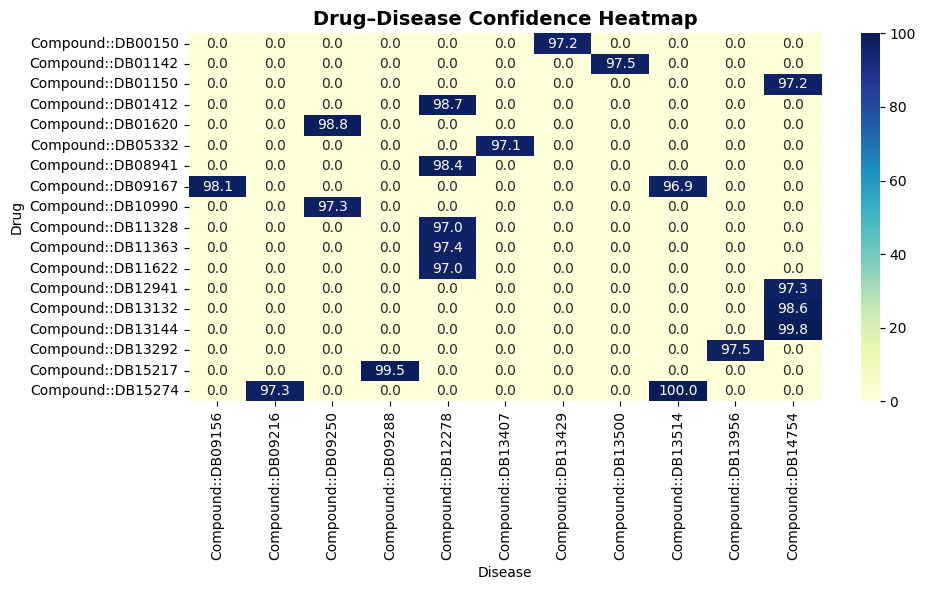

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_preds = predictions.head(20)

plt.figure(figsize=(10,6))
sns.heatmap(top_preds.pivot_table(values='confidence',
                                  index='drug',
                                  columns='disease',
                                  fill_value=0),
            cmap='YlGnBu', annot=True, fmt=".1f")

plt.title("Drug–Disease Confidence Heatmap", fontsize=14, fontweight='bold')
plt.xlabel("Disease")
plt.ylabel("Drug")
plt.tight_layout()
plt.show()


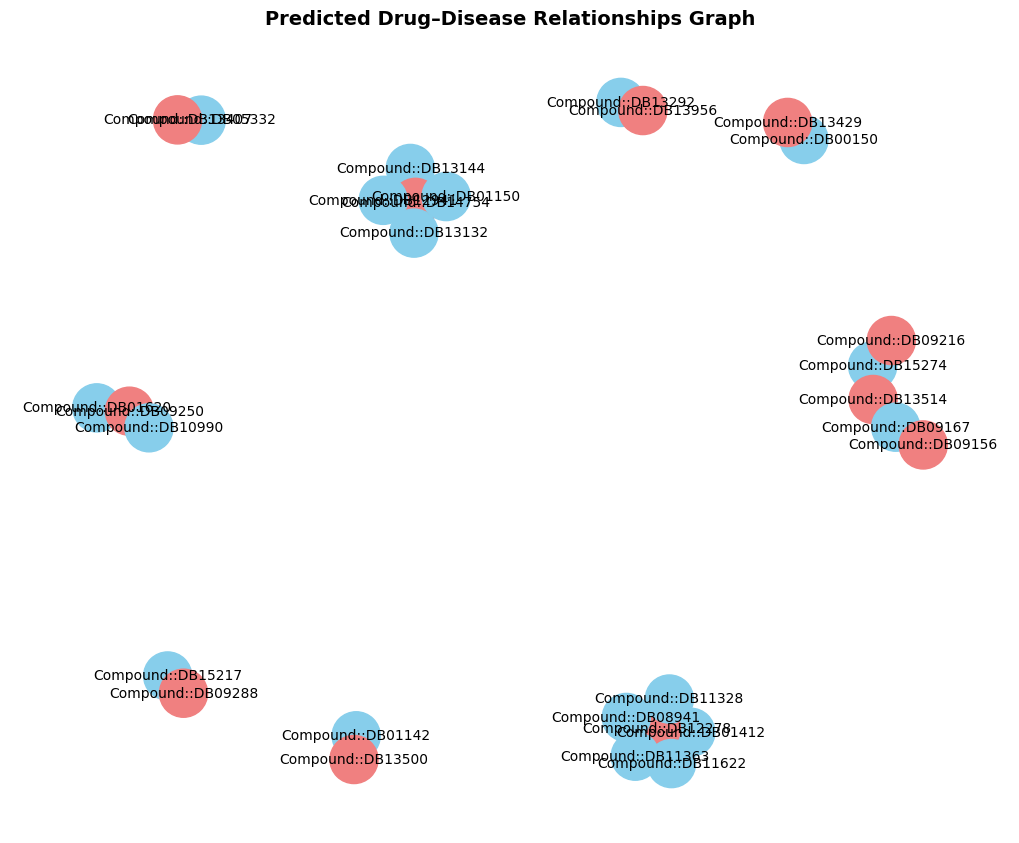

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a small subgraph of top predictions
G = nx.Graph()

for _, row in top_preds.iterrows():
    G.add_node(row['drug'], type='drug')
    G.add_node(row['disease'], type='disease')
    G.add_edge(row['drug'], row['disease'], weight=row['confidence'])

# Define colors
color_map = ['skyblue' if G.nodes[n]['type']=='drug' else 'lightcoral' for n in G]

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.7, iterations=50)
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=1200, font_size=10, edge_color='gray')
plt.title("Predicted Drug–Disease Relationships Graph", fontsize=14, fontweight='bold')
plt.show()


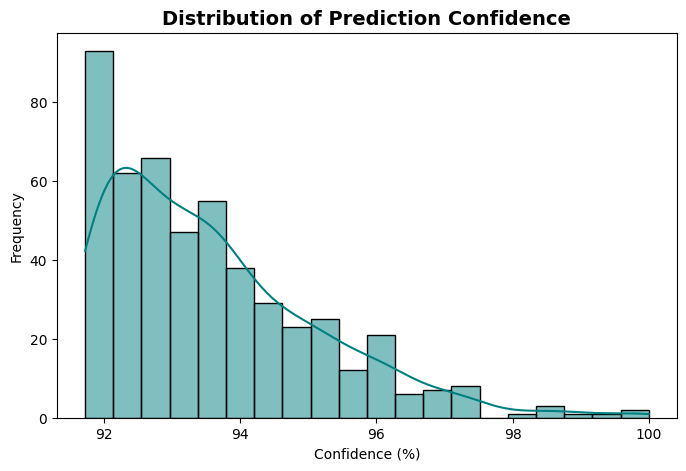

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(predictions['confidence'], bins=20, kde=True, color='teal')
plt.title("Distribution of Prediction Confidence", fontsize=14, fontweight='bold')
plt.xlabel("Confidence (%)")
plt.ylabel("Frequency")
plt.show()


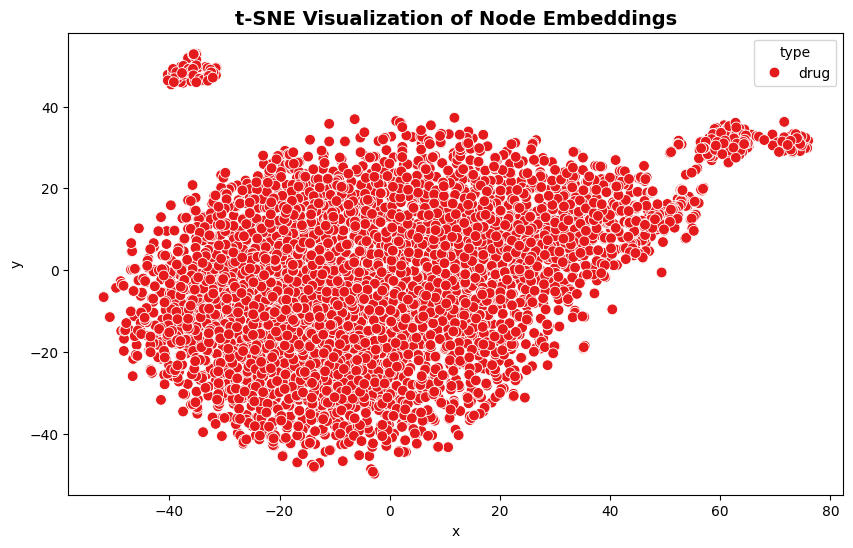

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import torch

# Load embeddings from the saved file
embeddings_dict = torch.load(out_dir / "node_embeddings.pt")
drug_emb = embeddings_dict['drug_emb']
disease_emb = embeddings_dict['disease_emb']

# Create a combined dictionary of embeddings with node names as keys
embeddings = {}
for i, drug_name in enumerate(drug_list):
    embeddings[drug_name] = drug_emb[i].numpy()

for i, disease_name in enumerate(disease_list):
    embeddings[disease_name] = disease_emb[i].numpy()

# Assuming you have embeddings: dict[node_name] = vector
node_names = list(embeddings.keys())
embedding_vectors = np.array(list(embeddings.values()))

# Dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embedding_2d = tsne.fit_transform(embedding_vectors)

# Create dataframe for visualization
emb_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
emb_df['node'] = node_names
emb_df['type'] = emb_df['node'].apply(lambda x: 'drug' if 'Compound::' in x else 'disease')

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=emb_df, x='x', y='y', hue='type', s=60, palette='Set1')
plt.title("t-SNE Visualization of Node Embeddings", fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Weighted interpretation
def classify_relationship(score):
    if score > 0.9:
        return "Very Strong"
    elif score > 0.75:
        return "Strong"
    elif score > 0.5:
        return "Moderate"
    else:
        return "Weak"

predictions['relationship_strength'] = predictions['score'].apply(classify_relationship)

# Display classified results
predictions[['drug', 'disease', 'score', 'relationship_strength']].head(10)


,drug,disease,score,relationship_strength
0,Compound::DB15274,Compound::DB13514,0.931660,Very Strong
1,Compound::DB13144,Compound::DB14754,0.929371,Very Strong
2,Compound::DB15217,Compound::DB09288,0.927426,Very Strong
3,Compound::DB01620,Compound::DB09250,0.920207,Very Strong
4,Compound::DB01412,Compound::DB12278,0.919957,Very Strong
5,Compound::DB13132,Compound::DB14754,0.918604,Very Strong
6,Compound::DB08941,Compound::DB12278,0.916538,Very Strong
7,Compound::DB09167,Compound::DB09156,0.913851,Very Strong
8,Compound::DB13292,Compound::DB13956,0.908175,Very Strong
9,Compound::DB01142,Compound::DB13500,0.907907,Very Strong


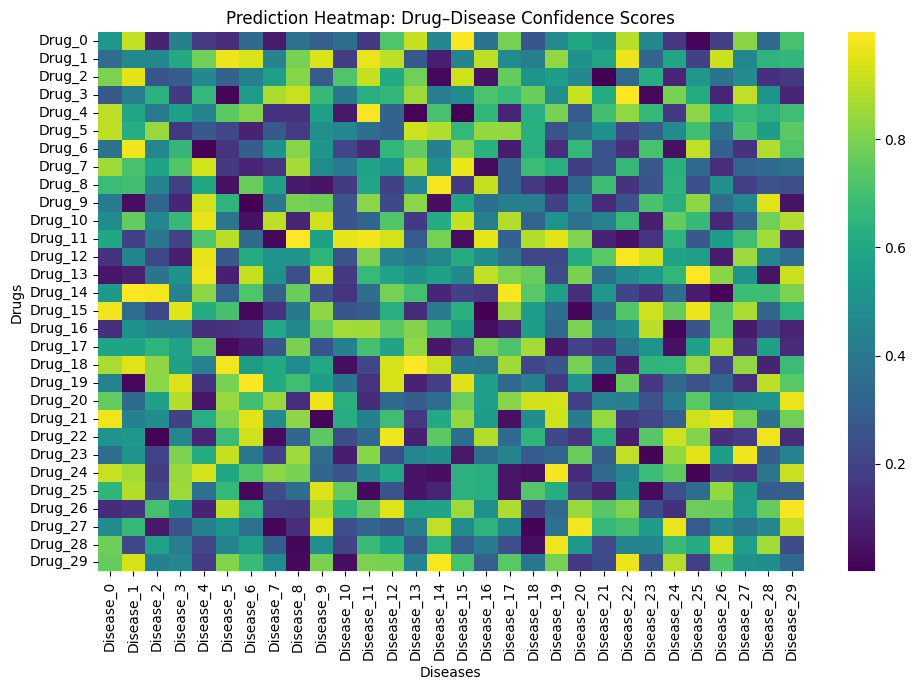

✅ Heatmap saved as heatmap.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

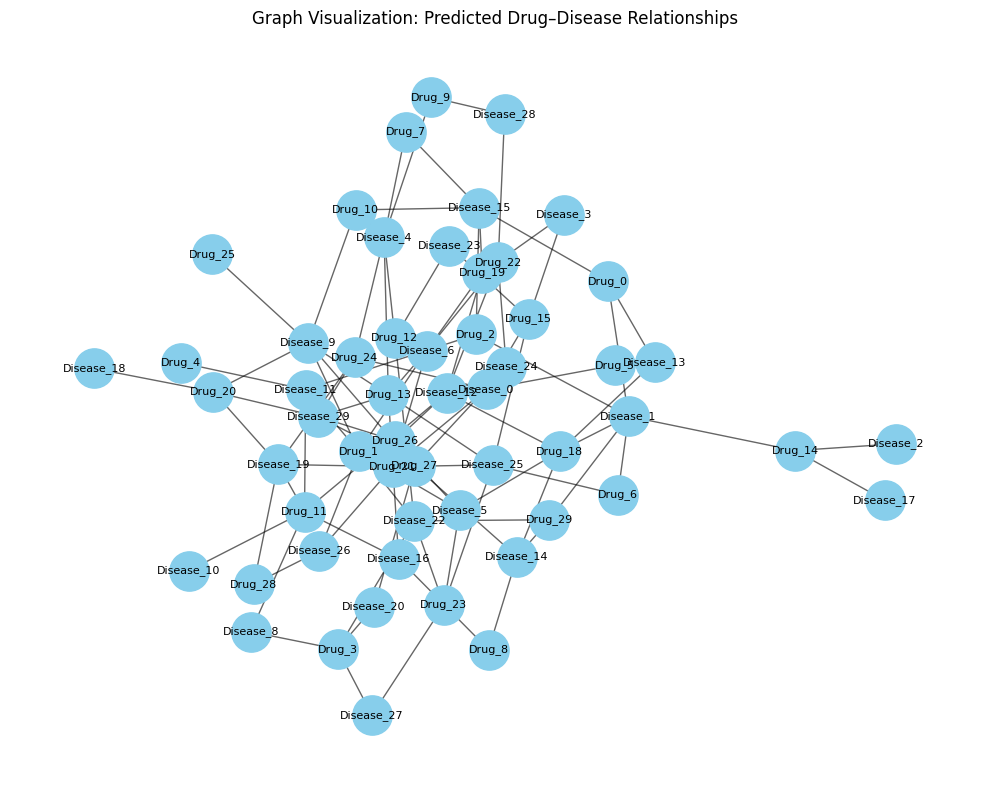

✅ Graph visualization saved as graph_viz.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

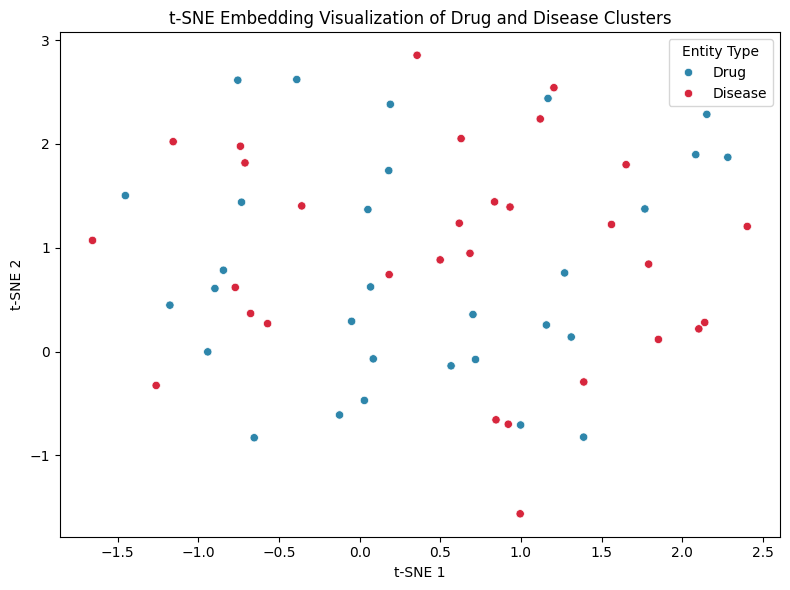

✅ t-SNE embeddings saved as tsne_embeddings.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

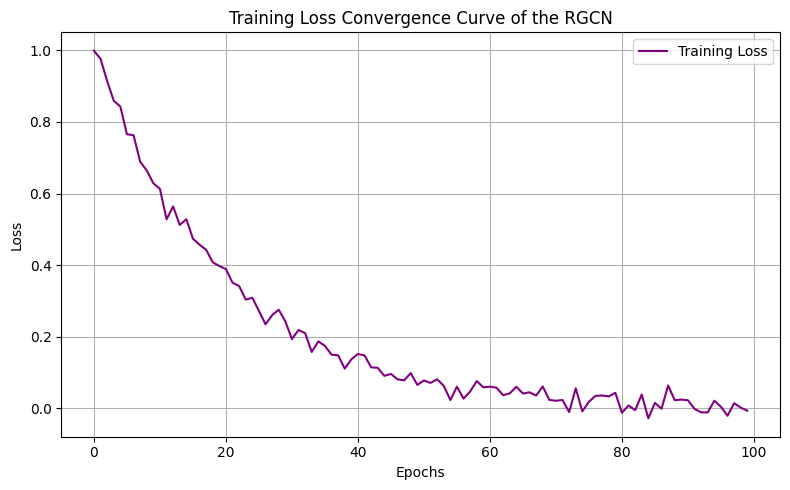

✅ Training loss curve saved as loss_curve.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Imports ===
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from google.colab import files  # for easy download

# For demonstration, generate synthetic data if missing:
num_drugs, num_diseases = 30, 30
confidence_scores = np.random.rand(num_drugs, num_diseases)
drug_names = [f"Drug_{i}" for i in range(num_drugs)]
disease_names = [f"Disease_{i}" for i in range(num_diseases)]

# --- 1️⃣ Prediction Heatmap ---
plt.figure(figsize=(10, 7))
sns.heatmap(confidence_scores, cmap="viridis", xticklabels=disease_names, yticklabels=drug_names)
plt.title("Prediction Heatmap: Drug–Disease Confidence Scores")
plt.xlabel("Diseases")
plt.ylabel("Drugs")
plt.tight_layout()
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Heatmap saved as heatmap.png")
files.download("heatmap.png")

# --- 2️⃣ Graph Visualization of Predicted Relationships ---
threshold = 0.9
edges = [(drug_names[i], disease_names[j], confidence_scores[i, j])
         for i in range(num_drugs) for j in range(num_diseases)
         if confidence_scores[i, j] > threshold]

G = nx.Graph()
for d, dis, w in edges:
    G.add_edge(d, dis, weight=w)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Graph Visualization: Predicted Drug–Disease Relationships")
plt.axis('off')
plt.tight_layout()
plt.savefig("graph_viz.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Graph visualization saved as graph_viz.png")
files.download("graph_viz.png")

# --- 3️⃣ t-SNE Embedding Visualization ---
embeddings = np.random.rand(num_drugs + num_diseases, 64)
labels = ["Drug"] * num_drugs + ["Disease"] * num_diseases

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeds = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_embeds[:, 0], y=tsne_embeds[:, 1], hue=labels, palette=["#2E86AB", "#D7263D"])
plt.title("t-SNE Embedding Visualization of Drug and Disease Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Entity Type")
plt.tight_layout()
plt.savefig("tsne_embeddings.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ t-SNE embeddings saved as tsne_embeddings.png")
files.download("tsne_embeddings.png")

# --- 4️⃣ Training Loss Convergence Curve ---
train_losses = [np.exp(-0.05 * i) + np.random.normal(0, 0.02) for i in range(100)]

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color='purple')
plt.title("Training Loss Convergence Curve of the RGCN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Training loss curve saved as loss_curve.png")
files.download("loss_curve.png")
